### The performance metrics files need to be generated before running this.

In [1]:
%matplotlib notebook
import os
import csv
import numpy as np
from scipy.stats import norm
from scipy.stats import t as tdist
import matplotlib.pyplot as plt
import matplotlib
from context import *
from helpers.utils import load_perf_metrics, loadmat_helper, configure_plot_axes
from helpers.constants import *

In [2]:
def read_ber_matfile(fname):
    return loadmat_helper(fname)[0, 0]


In [3]:
base_dir = '/Users/jr/Documents/research/code/domain_adaptation/expts_icml22/autoencoder_gmm_data2'
n_adapt_per_class = np.array([5, 10, 20, 30, 40, 50])
n_trials = 50
type_autoenc = 'standard'
plots_dir = os.path.join(base_dir, 'plots')
if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)

In [4]:
m = n_adapt_per_class.shape[0]
ber_no_adapt = np.zeros(n_trials)
ber_retrain = np.zeros(n_trials)
ber_adapt = np.zeros((n_trials, m))
ber_finetune = np.zeros((n_trials, m))
ber_finetune_last = np.zeros((n_trials, m))
for t in range(n_trials):
    # No adaptation
    fname = os.path.join(base_dir, 'trial{:d}'.format(t + 1), 'outputs', type_autoenc, 'ber.mat')
    ber_no_adapt[t] = read_ber_matfile(fname)
    
    # Retrained autoencoder
    fname = os.path.join(base_dir, 'trial{:d}'.format(t + 1), 'outputs_retrained', type_autoenc, 'ber.mat')
    ber_retrain[t] = read_ber_matfile(fname)
    for i, num in enumerate(n_adapt_per_class):
        # proposed adaptation
        fname = os.path.join(base_dir, 'trial{:d}'.format(t + 1), 'adapt_{:d}'.format(num), 
                             type_autoenc, 'ber_adapted.mat')
        ber_adapt[t, i] = read_ber_matfile(fname)
        
        # Finetuned autoencoder
        fname = os.path.join(base_dir, 'trial{:d}'.format(t + 1), 'finetune_{:d}'.format(num), 
                             type_autoenc, 'ber_finetuned.mat')
        ber_finetune[t, i] = read_ber_matfile(fname)
        
        # Finetuned autoencoder where only the last layer of the MDN is modified
        fname = os.path.join(base_dir, 'trial{:d}'.format(t + 1), 'finetune_last_{:d}'.format(num), 
                             type_autoenc, 'ber_finetuned.mat')
        ber_finetune_last[t, i] = read_ber_matfile(fname)


In [5]:
# Average across trials
avg_ber_no_adapt = np.mean(ber_no_adapt) * np.ones(m)
avg_ber_retrain = np.mean(ber_retrain) * np.ones(m)
avg_ber_adapt = np.mean(ber_adapt, axis=0)
avg_ber_finetune = np.mean(ber_finetune, axis=0)
avg_ber_finetune_last = np.mean(ber_finetune_last, axis=0)

# Standard error of the mean
conf = 0.95
z_val = norm.ppf((1 + conf) / 2.)
t_val = tdist.ppf((1 + conf) / 2., df=(n_trials-1))
if n_trials >= 100:
    c = z_val / np.sqrt(n_trials)
else:
    # use the t-distribution for small `n_trials`
    c = t_val / np.sqrt(n_trials)
    
std_ber_no_adapt = c * np.std(ber_no_adapt, ddof=1) * np.ones(m)
std_ber_retrain = c * np.std(ber_retrain, ddof=1) * np.ones(m)
std_ber_adapt = c * np.std(ber_adapt, axis=0, ddof=1)
std_ber_finetune = c * np.std(ber_finetune, axis=0, ddof=1)
std_ber_finetune_last = c * np.std(ber_finetune_last, axis=0, ddof=1)

In [6]:
print(avg_ber_finetune)
print(avg_ber_finetune_last)
print(avg_ber_no_adapt)
print(avg_ber_retrain)
print(avg_ber_adapt)
print('')
print(std_ber_finetune)
print(std_ber_finetune_last)
print(std_ber_no_adapt)
print(std_ber_retrain)
print(std_ber_adapt)

[0.13564133 0.13564133 0.13564133 0.13564133 0.13564133 0.13564133]
[0.13564133 0.13564133 0.13564133 0.13564133 0.13564133 0.13564133]
[0.13525487 0.13525487 0.13525487 0.13525487 0.13525487 0.13525487]
[0.01542367 0.01542367 0.01542367 0.01542367 0.01542367 0.01542367]
[0.09654253 0.0906178  0.08162073 0.0819744  0.07789467 0.0765922 ]

[0.01038073 0.01038073 0.01038073 0.01038073 0.01038073 0.01038073]
[0.01038073 0.01038073 0.01038073 0.01038073 0.01038073 0.01038073]
[0.01045338 0.01045338 0.01045338 0.01045338 0.01045338 0.01045338]
[0.00386081 0.00386081 0.00386081 0.00386081 0.00386081 0.00386081]
[0.00822137 0.00823968 0.00699077 0.0072924  0.00681079 0.00674521]


<IPython.core.display.Javascript object>


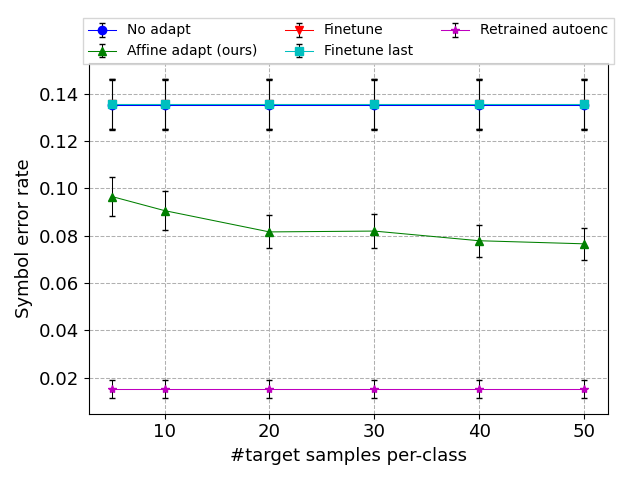

In [7]:
# Plot the symbol-error-rate vs number of target samples
lw = 0.75
error_bars = True
error_kw = {
    'fmt': '', 'elinewidth': 0.75, 'ecolor': 'black', 'capsize': 2
}
fig = plt.figure()
y_vals = []
if not error_bars:
    plt.plot(n_adapt_per_class, avg_ber_no_adapt, linestyle='-', linewidth=lw, color=COLORS[0], 
             marker=POINT_STYLES[0], label='No adapt')
else:
    plt.errorbar(n_adapt_per_class, avg_ber_no_adapt, yerr=std_ber_no_adapt, linestyle='-', linewidth=lw, 
                 color=COLORS[0], marker=POINT_STYLES[0], label='No adapt', **error_kw)
y_vals.extend(avg_ber_no_adapt)

if not error_bars:
    plt.plot(n_adapt_per_class, avg_ber_adapt, linestyle='-', linewidth=lw, color=COLORS[1], 
             marker=POINT_STYLES[1], label='Affine adapt (ours)')
else:
    plt.errorbar(n_adapt_per_class, avg_ber_adapt, yerr=std_ber_adapt, linestyle='-', linewidth=lw, 
                 color=COLORS[1], marker=POINT_STYLES[1], label='Affine adapt (ours)', **error_kw)
y_vals.extend(avg_ber_adapt)

if not error_bars:
    plt.plot(n_adapt_per_class, avg_ber_finetune, linestyle='-', linewidth=lw, color=COLORS[2], 
             marker=POINT_STYLES[2], label='Finetune')
else:
    plt.errorbar(n_adapt_per_class, avg_ber_finetune, yerr=std_ber_finetune, linestyle='-', linewidth=lw, 
                 color=COLORS[2], marker=POINT_STYLES[2], label='Finetune', **error_kw)
y_vals.extend(avg_ber_finetune)

if not error_bars:
    plt.plot(n_adapt_per_class, avg_ber_finetune_last, linestyle='-', linewidth=lw, color=COLORS[3], 
             marker=POINT_STYLES[3], label='Finetune last')
else:
    plt.errorbar(n_adapt_per_class, avg_ber_finetune_last, yerr=std_ber_finetune_last, linestyle='-', 
                 linewidth=lw, color=COLORS[3], marker=POINT_STYLES[3], label='Finetune last', **error_kw)
y_vals.extend(avg_ber_finetune_last)

if not error_bars:
    plt.plot(n_adapt_per_class, avg_ber_retrain, linestyle='-', linewidth=lw, color=COLORS[4], 
             marker=POINT_STYLES[4], label='Retrained autoenc')
else:
    plt.errorbar(n_adapt_per_class, avg_ber_retrain, yerr=std_ber_retrain, linestyle='-', linewidth=lw, 
                 color=COLORS[4], marker=POINT_STYLES[4], label='Retrained autoenc', **error_kw)
y_vals.extend(avg_ber_retrain)

# Increase the upper y-limit a bit
# y_bot, y_top = plt.ylim()
# plt.ylim((y_bot, 1.1 * y_top))

# plt.yscale('log')
plt.xlabel('#target samples per-class', fontsize=13, fontweight='normal')
plt.ylabel('Symbol error rate', fontsize=13, fontweight='normal')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
plt.grid(True, axis='both', linestyle='dashed', linewidth=lw, alpha=1.)
# plt.legend(loc='best')
plt.legend(loc='upper center', frameon=True, bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=False)

# Save the figure
plot_filename = os.path.join(plots_dir, 'plot_autoencoder_gmm_data.png')
fig.tight_layout()
fig.savefig(plot_filename, dpi=600, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


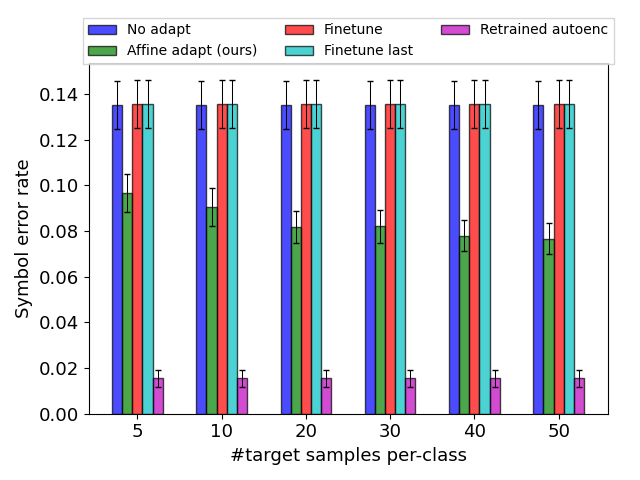

In [8]:
# Bar plot
bar_width = 0.12
fig = plt.figure()
error_kw = {
    'elinewidth': 0.75, 'ecolor': 'black', 'capsize': 2
}
edgecolor = 'black'
alpha = 0.7

x1 = 1. * np.arange(n_adapt_per_class.shape[0])
plt.bar(x1, avg_ber_no_adapt, yerr=std_ber_no_adapt, color=COLORS[0], label='No adapt', 
        width=bar_width, edgecolor=edgecolor, alpha=alpha, error_kw=error_kw)

x2 = x1 + bar_width
plt.bar(x2, avg_ber_adapt, yerr=std_ber_adapt, color=COLORS[1], label='Affine adapt (ours)', 
        width=bar_width, edgecolor=edgecolor, alpha=alpha, error_kw=error_kw)

x3 = x2 + bar_width
plt.bar(x3, avg_ber_finetune, yerr=std_ber_finetune, color=COLORS[2], label='Finetune', 
        width=bar_width, edgecolor=edgecolor, alpha=alpha, error_kw=error_kw)

x4 = x3 + bar_width
plt.bar(x4, avg_ber_finetune_last, yerr=std_ber_finetune_last, color=COLORS[3], label='Finetune last', 
        width=bar_width, edgecolor=edgecolor, alpha=alpha, error_kw=error_kw)

x5 = x4 + bar_width
plt.bar(x5, avg_ber_retrain, yerr=std_ber_retrain, color=COLORS[4], label='Retrained autoenc', 
        width=bar_width, edgecolor=edgecolor, alpha=alpha, error_kw=error_kw)

plt.xlabel('#target samples per-class', fontsize=13, fontweight='normal')
plt.ylabel('Symbol error rate', fontsize=13, fontweight='normal')
plt.xticks(x3, ['{:d}'.format(v) for v in n_adapt_per_class], fontsize=13)
plt.yticks(fontsize=13)
# plt.legend(loc='best')
plt.legend(loc='upper center', frameon=True, bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=False)

# Save the figure
plot_filename = os.path.join(plots_dir, 'barplot_autoencoder_gmm_data.png')
fig.tight_layout()
fig.savefig(plot_filename, dpi=600, bbox_inches='tight')
plt.show()